# Notebook 02 — FFT-Based Carpet Severity Metric (Part 1)

This notebook implements the carpet severity metric required by the challenge.

Challenge-aligned definition:
- Carpet: spectral peaks randomly close to each other (irregular spacing)
- Non-carpet: regularly spaced peaks (harmonic-like spacing)

Why FFT (vs Welch PSD):
Welch PSD is a stable diagnostic representation (Notebook 01), but it can smooth peak microstructure.
Because the challenge requires analysis of peak spacing regularity, we use FFT magnitude to preserve
peak positions and spacing information.

Deliverables from this notebook:
1. Peak extraction in a target frequency band (>= 1000 Hz).
2. Metrics that quantify irregular peak spacing and peak clustering.
3. A carpet severity score per sample.
4. Identification of the sample with the worst carpet symptom.


## 1. Setup and Data Access

This section imports utilities from the repository and defines global parameters used consistently across all samples.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tractian_cm.io.loaders import load_part1_wave_csv


In [2]:
CFG = {
    "k_peak": 6.0,
    "min_distance_hz": 5.0,
    "gap_max_hz": 35.0,
    "min_peaks_cluster": 8,
    "top_k_clusters": 1,
    "fmin_hz": 1000.0,
}

In [3]:
def fft_magnitude_single_sided(x: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    """
    EN: Compute single-sided FFT magnitude with Hann window to reduce leakage.
    EN: Returns frequency axis (Hz) and magnitude spectrum (linear).
    """
    x = np.asarray(x, dtype=float)
    n = x.size

    # EN: Detrend by removing mean (DC)
    x = x - np.mean(x)

    # EN: Apply Hann window
    w = np.hanning(n)
    xw = x * w

    # EN: rFFT -> single-sided spectrum
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1.0 / fs)

    # EN: Magnitude normalization (relative comparison; not absolute calibration)
    mag = np.abs(X) / (np.sum(w) / 2.0)

    return f, mag


## 2. FFT Magnitude Spectrum (Single-Sided)

We compute the single-sided FFT magnitude spectrum to preserve peak microstructure.

Key choices:
- Use a window (Hann) to reduce leakage.
- Use amplitude normalization only for comparability (absolute scale is not required).
- Focus on frequencies >= 1000 Hz as specified by the challenge.


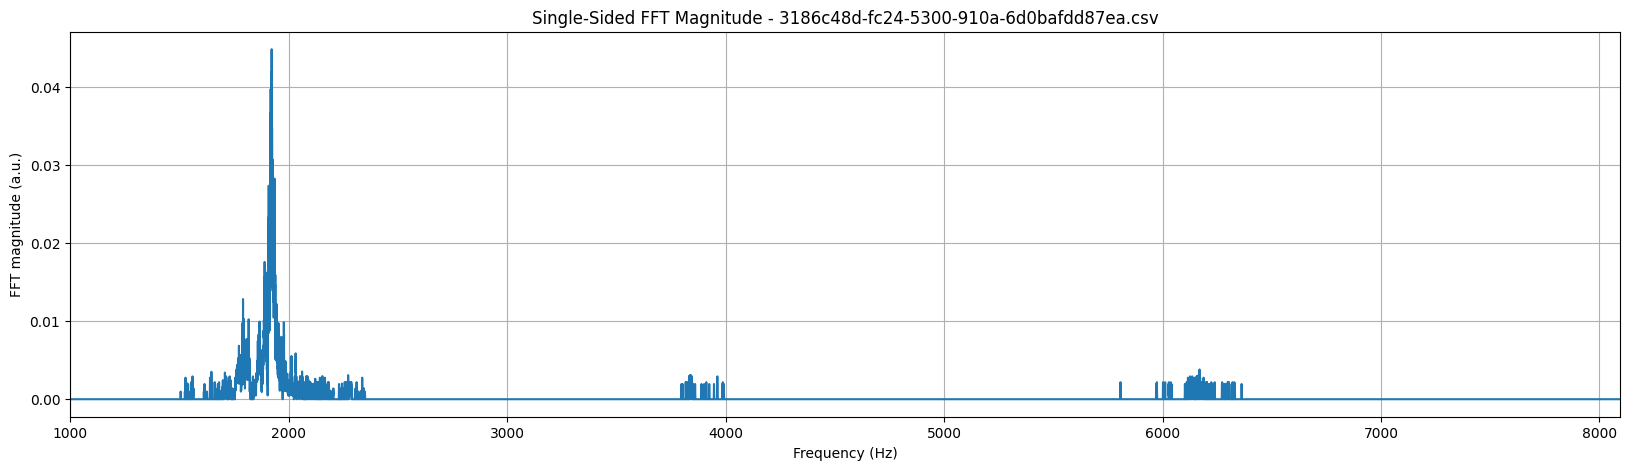

In [4]:
p = Path("../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv")

wave, fs = load_part1_wave_csv(p)
x = np.asarray(wave.signal, dtype=float)

f, mag = fft_magnitude_single_sided(x, fs)

band = f >= 1000.0
plt.figure(figsize=(20,5))
plt.plot(f[band], mag[band])
plt.xlim(1000, f.max())
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT magnitude (a.u.)")
plt.title(f"Single-Sided FFT Magnitude - {p.name}")
plt.grid()
plt.show()


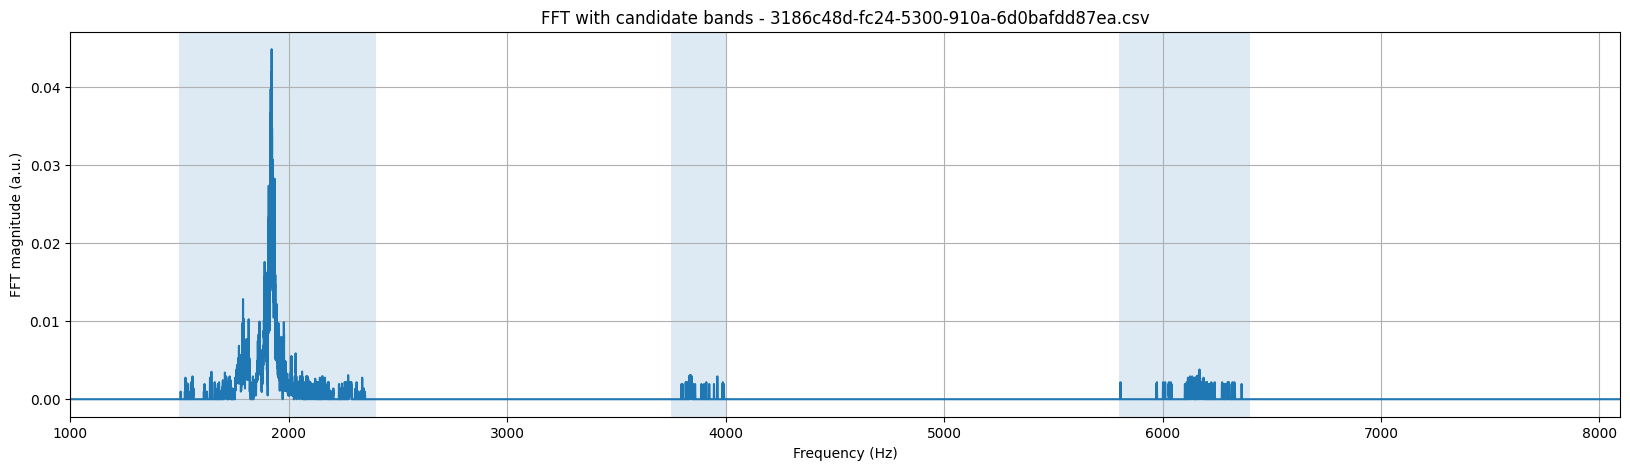

In [5]:
bands = [
    (1500, 2400),
    (3750, 4000),
    (5800, 6400),
]

plt.figure(figsize=(20,5))
plt.plot(f[band], mag[band])
for a,b in bands:
    plt.axvspan(a, b, alpha=0.15)
plt.xlim(1000, f.max())
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT magnitude (a.u.)")
plt.grid()
plt.title(f"FFT with candidate bands - {p.name}")
plt.show()


## 3. Peak Extraction

We extract peaks from the FFT magnitude spectrum within the analysis band.

Peak detection must be robust to different global amplitudes across samples, so thresholds are defined relative to a local / global baseline (e.g., median + k * MAD).


In [6]:
from scipy.signal import find_peaks

def mad(x: np.ndarray) -> float:
    """EN: Median Absolute Deviation (robust scale estimator)."""
    m = np.median(x)
    return float(np.median(np.abs(x - m)))

def extract_peaks_in_band(f: np.ndarray, mag: np.ndarray, fmin: float, fmax: float,
                          k: float = 6.0, min_distance_hz: float = 5.0):
    """
    EN: Extract peaks using robust thresholding in a frequency band.
    Returns peak frequencies (Hz) and peak magnitudes.
    """
    sel = (f >= fmin) & (f <= fmax)
    fb = f[sel]
    xb = mag[sel]

    scale = mad(xb)
    thr = np.median(xb) + k * scale

    df = float(np.median(np.diff(fb)))
    min_dist_bins = max(1, int(round(min_distance_hz / df)))

    peaks, props = find_peaks(xb, height=thr, distance=min_dist_bins)
    fpk = fb[peaks]
    mpk = xb[peaks]
    return fpk, mpk, thr


## 4. Metrics for Carpet vs Non-Carpet

We propose and compare metrics designed to differentiate:
- Regularly spaced peaks (harmonic-like): low variability in peak-to-peak spacing
- Irregularly clustered peaks (carpet-like): high variability + high local density

Candidate metrics:
1) Spacing variability: CV of Δf between consecutive peak frequencies
2) Local peak density: peaks per kHz (or peaks per window)
3) Periodicity penalty: strength of periodic spacing (optional, via autocorrelation of peak indicator sequence)


In [7]:
def spacing_cv(fpk: np.ndarray) -> float:
    """EN: Coefficient of variation of consecutive peak spacings."""
    if fpk.size < 3:
        return float("nan")
    df = np.diff(fpk)
    mu = float(np.mean(df))
    if mu == 0:
        return float("nan")
    return float(np.std(df) / mu)

def peak_density(fpk: np.ndarray, fmin: float, fmax: float) -> float:
    """EN: Peaks per kHz."""
    bw_khz = (fmax - fmin) / 1000.0
    return float(fpk.size / bw_khz) if bw_khz > 0 else float("nan")

def peak_dominance_ratio(mpk: np.ndarray) -> float:
    """EN: Peak dominance in linear magnitude."""
    if mpk.size == 0:
        return float("nan")
    med = float(np.median(mpk))
    return float(np.max(mpk) / (med + 1e-12))


## 5. Carpet Severity Score

We define a severity score that increases with:
- Peak density (more peaks per band)
- Spacing irregularity (higher CV of Δf)
and is reduced when the spectrum is dominated by one or a few peaks (peak dominance filter).

**Interpretation:
Higher severity score indicates stronger carpet-like behavior.**


We then compute the score per sample and rank samples to identify the worst carpet symptom.


In [8]:
for (a,b) in bands:
    fpk, mpk, thr = extract_peaks_in_band(f, mag, a, b, k=6.0, min_distance_hz=5.0)
    dens = peak_density(fpk, a, b)
    cv = spacing_cv(fpk)
    dom = peak_dominance_ratio(mpk)
    print(f"Band {a}-{b} Hz | peaks={len(fpk)} | density={dens:.1f}/kHz | spacing_CV={cv:.2f} | dominance={dom:.2f} | thr={thr:.4f}")


Band 1500-2400 Hz | peaks=26 | density=28.9/kHz | spacing_CV=0.80 | dominance=4.57 | thr=0.0048
Band 3750-4000 Hz | peaks=15 | density=60.0/kHz | spacing_CV=0.54 | dominance=1.58 | thr=0.0000
Band 5800-6400 Hz | peaks=34 | density=56.7/kHz | spacing_CV=1.73 | dominance=1.75 | thr=0.0000


### 5.1 Dynamic Peak Clustering (Gap-Based)

To avoid relying on fixed band widths, we form candidate carpet regions directly from FFT peak positions.

Approach:
- Extract peaks in the analysis band (>= 1000 Hz).
- Sort peak frequencies.
- Start a cluster and keep adding peaks while consecutive peak gaps remain below `gap_max_hz`.
- Each cluster defines a dynamic band: [min(f_peak), max(f_peak)].

This operationalizes the challenge definition of "peaks randomly close to each other" using a physically interpretable proximity threshold (`gap_max_hz`).


In [9]:
from dataclasses import dataclass

@dataclass(frozen=True)
class PeakCluster:
    """EN: Represents a cluster of FFT peaks within a dynamic frequency band."""
    f_start_hz: float
    f_end_hz: float
    f_peaks_hz: np.ndarray
    m_peaks: np.ndarray

def cluster_peaks_by_gap(
    fpk: np.ndarray,
    mpk: np.ndarray,
    gap_max_hz: float = 25.0,
    min_peaks: int = 8,
) -> list[PeakCluster]:
    """
    EN: Cluster peaks by grouping consecutive peaks whose spacing is <= gap_max_hz.
    EN: Returns clusters that contain at least min_peaks peaks.
    """
    fpk = np.asarray(fpk, dtype=float)
    mpk = np.asarray(mpk, dtype=float)

    if fpk.size == 0:
        return []

    # EN: sort by frequency
    order = np.argsort(fpk)
    fpk = fpk[order]
    mpk = mpk[order]

    clusters: list[PeakCluster] = []
    start = 0

    for i in range(1, fpk.size):
        if (fpk[i] - fpk[i - 1]) > gap_max_hz:
            # EN: finalize current cluster [start, i)
            if (i - start) >= min_peaks:
                f_seg = fpk[start:i]
                m_seg = mpk[start:i]
                clusters.append(
                    PeakCluster(
                        f_start_hz=float(f_seg[0]),
                        f_end_hz=float(f_seg[-1]),
                        f_peaks_hz=f_seg,
                        m_peaks=m_seg,
                    )
                )
            start = i

    # EN: finalize last cluster [start, end)
    if (fpk.size - start) >= min_peaks:
        f_seg = fpk[start:]
        m_seg = mpk[start:]
        clusters.append(
            PeakCluster(
                f_start_hz=float(f_seg[0]),
                f_end_hz=float(f_seg[-1]),
                f_peaks_hz=f_seg,
                m_peaks=m_seg,
            )
        )

    return clusters


### 5.2 Cluster Scoring and Sample Severity Aggregation

For each peak cluster we compute:

- Peak density: peaks per kHz inside the dynamic band
- Spacing irregularity: CV of consecutive peak spacings (Δf)
- Peak dominance: ratio between max and median peak magnitude

A carpet severity score should:
- Increase with density and spacing irregularity
- Decrease when a cluster is dominated by a few peaks

We compute a per-cluster score and aggregate per sample as the sum of the top-k cluster scores.


In [10]:
def cluster_metrics_and_score(cluster: PeakCluster) -> dict:
    """
    EN: Compute metrics and a severity score for a peak cluster.
    """
    fpk = cluster.f_peaks_hz
    mpk = cluster.m_peaks

    width_hz = float(cluster.f_end_hz - cluster.f_start_hz)
    width_khz = width_hz / 1000.0 if width_hz > 0 else np.nan

    # EN: Peak density (peaks per kHz)
    density = float(fpk.size / width_khz) if np.isfinite(width_khz) and width_khz > 0 else float("nan")

    # EN: Spacing CV over consecutive peak gaps
    if fpk.size >= 3:
        df = np.diff(fpk)
        mu = float(np.mean(df))
        spacing_cv_val = float(np.std(df) / mu) if mu > 0 else float("nan")
    else:
        spacing_cv_val = float("nan")

    # EN: Peak dominance ratio in linear magnitude
    if mpk.size:
        med = float(np.median(mpk))
        dominance = float(np.max(mpk) / (med + 1e-12))
    else:
        dominance = float("nan")

    # EN: Interpretable severity score:
    # EN: density ↑, spacing irregularity ↑, dominance ↓
    score = (
        float(density * spacing_cv_val / (dominance + 1e-12))
        if np.isfinite(density) and np.isfinite(spacing_cv_val) and np.isfinite(dominance)
        else float("nan")
    )

    return {
        "f_start_hz": cluster.f_start_hz,
        "f_end_hz": cluster.f_end_hz,
        "n_peaks": int(fpk.size),
        "width_hz": width_hz,
        "density_per_khz": density,
        "spacing_cv": spacing_cv_val,
        "dominance": dominance,
        "score": score,
    }


def sample_severity_from_clusters(cluster_scores: list[dict], top_k: int = 2) -> float:
    """
    EN: Aggregate severity across clusters as the sum of top-k cluster scores.
    """
    scores = [d["score"] for d in cluster_scores if np.isfinite(d["score"])]
    if not scores:
        return 0.0
    scores_sorted = sorted(scores, reverse=True)
    return float(np.sum(scores_sorted[:top_k]))


def plot_fft_with_clusters(
    f: np.ndarray,
    mag: np.ndarray,
    clusters: list[PeakCluster],
    fmin: float = 1000.0,
    fmax: float | None = None,
    title: str | None = None,
) -> None:
    """
    EN: Plot FFT magnitude and overlay shaded cluster regions and peak markers.
    """
    f = np.asarray(f, dtype=float)
    mag = np.asarray(mag, dtype=float)

    if fmax is None:
        fmax = float(f.max())

    sel = (f >= fmin) & (f <= fmax)
    fp = f[sel]
    mp = mag[sel]

    plt.figure(figsize=(20,5))
    plt.plot(fp, mp)

    # EN: overlay cluster bands and their peaks
    for c in clusters:
        a, b = c.f_start_hz, c.f_end_hz
        if b < fmin or a > fmax:
            continue
        plt.axvspan(max(a, fmin), min(b, fmax), alpha=0.15)
        plt.scatter(c.f_peaks_hz, c.m_peaks, s=12)

    plt.xlim(fmin, fmax)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("FFT magnitude (a.u.)")
    plt.title(title or "FFT magnitude with clustered peak regions")
    plt.show()


File: 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv | fs=16188.0 | peaks=147 | clusters=5 | sample_score(top2)=105.421
  C1: 6273.0-6328.9 Hz | n=8 | dens=143.3/kHz | cv=0.45 | dom=1.00 | score=64.44
  C2: 3798.5-3860.8 Hz | n=8 | dens=128.5/kHz | cv=0.48 | dom=1.49 | score=40.98
  C3: 2231.0-2345.1 Hz | n=13 | dens=113.9/kHz | cv=0.47 | dom=1.53 | score=34.62
  C4: 6093.2-6239.0 Hz | n=20 | dens=137.2/kHz | cv=0.25 | dom=1.75 | score=19.32
  C5: 1615.4-2205.3 Hz | n=78 | dens=132.2/kHz | cv=0.35 | dom=15.32 | score=3.06


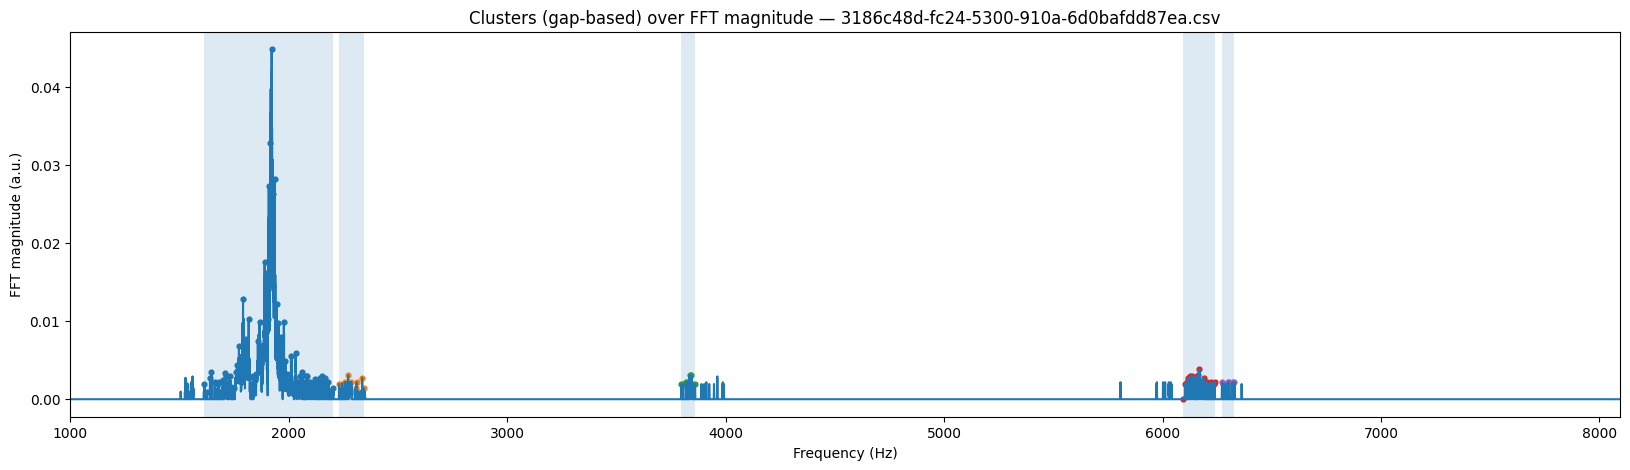

In [11]:
# --- Apply to a single candidate file (diagnostic before scaling to all samples) ---
p = Path("../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv")
wave, fs = load_part1_wave_csv(p)
x = np.asarray(wave.signal, dtype=float)

f, mag = fft_magnitude_single_sided(x, fs)

# EN: Analyze only above 1000 Hz (challenge-aligned band)
mask = f >= 1000.0
fb = f[mask]
mb = mag[mask]

# EN: Robust peak extraction across the analysis band
fpk, mpk, thr = extract_peaks_in_band(
    fb, mb,
    fmin=1000.0,
    fmax=float(fb.max()),
    k=6.0,
    min_distance_hz=5.0
)

clusters = cluster_peaks_by_gap(fpk, mpk, gap_max_hz=25.0, min_peaks=8)
cluster_scores = [cluster_metrics_and_score(c) for c in clusters]
sample_score = sample_severity_from_clusters(cluster_scores, top_k=2)

print(f"File: {p.name} | fs={fs:.1f} | peaks={len(fpk)} | clusters={len(clusters)} | sample_score(top2)={sample_score:.3f}")
for i, d in enumerate(sorted(cluster_scores, key=lambda z: z['score'], reverse=True), start=1):
    print(
        f"  C{i}: {d['f_start_hz']:.1f}-{d['f_end_hz']:.1f} Hz | "
        f"n={d['n_peaks']} | dens={d['density_per_khz']:.1f}/kHz | "
        f"cv={d['spacing_cv']:.2f} | dom={d['dominance']:.2f} | score={d['score']:.2f}"
    )

plot_fft_with_clusters(
    f=fb,
    mag=mb,
    clusters=clusters,
    fmin=1000.0,
    fmax=float(fb.max()),
    title=f"Clusters (gap-based) over FFT magnitude — {p.name}",
)

In [12]:
def compute_rms_for_file(path: Path) -> float:
    """EN: Compute RMS of the vibration signal for a given file."""
    wave, fs = load_part1_wave_csv(path)
    x = np.asarray(wave.signal, dtype=float)
    return float(np.sqrt(np.mean(x * x)))

# EN: Load all Part 1 files
all_paths = sorted(Path("../data/part_1").glob("*.csv"))

# EN: Compute RMS for all files
rms_list = []
for p in all_paths:
    rms_val = compute_rms_for_file(p)
    rms_list.append((p, rms_val))

# EN: Sort by RMS (ascending)
rms_list_sorted = sorted(rms_list, key=lambda x: x[1])

# EN: Select 10 evenly spaced indices across RMS distribution
indices = np.linspace(0, len(rms_list_sorted) - 1, 10, dtype=int)
selected_paths = [rms_list_sorted[i][0] for i in indices]

selected_paths


[WindowsPath('../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv'),
 WindowsPath('../data/part_1/11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv'),
 WindowsPath('../data/part_1/b3f7bc7a-5414-5112-9028-49f4fd4a9072.csv'),
 WindowsPath('../data/part_1/ce31ebce-aa58-5112-9643-89c4559dd5ae.csv'),
 WindowsPath('../data/part_1/9da3a9bb-65e4-5899-9280-cdd730913e87.csv'),
 WindowsPath('../data/part_1/ccd17931-56bc-5470-8a47-89356b267edd.csv'),
 WindowsPath('../data/part_1/82e91f2f-4ed5-5591-9617-0ff6f3b0e0c1.csv'),
 WindowsPath('../data/part_1/ad57d6b2-f816-5bb2-b4e8-191404207168.csv'),
 WindowsPath('../data/part_1/b4cbcfe4-09db-5bd3-ae42-c6bf0ab67b91.csv'),
 WindowsPath('../data/part_1/75a0970d-7c9a-5fd4-9a83-80cddf68ce6c.csv')]

## 6. Ranking and Diagnostics (Reproducible Sample Selection)

To ensure methodological consistency with Notebook 01,
we evaluate the same 10 representative samples.

Selection strategy:

- Compute RMS for all Part 1 files.
- Sort files by RMS (ascending).
- Select 10 evenly spaced samples across the RMS distribution.

Rationale:

- RMS is a proxy for global vibration energy.
- Evenly sampling across RMS avoids bias toward only low or high severity cases.
- This guarantees comparability between PSD-based diagnostics (Notebook 01)
  and FFT-based carpet severity metric (Notebook 02).

After validating the metric on these representative samples,
the final ranking can be extended to all available files.


In [13]:
def rms(x: np.ndarray) -> float:
    """EN: Root mean square of a time signal."""
    x = np.asarray(x, dtype=float)
    return float(np.sqrt(np.mean(x * x)))

def score_file_carpet(
    path: Path,
    k_peak: float = CFG["k_peak"],
    min_distance_hz: float = CFG["min_distance_hz"],
    gap_max_hz: float = CFG["gap_max_hz"],
    min_peaks_cluster: int = CFG["min_peaks_cluster"],
    top_k_clusters: int = CFG["top_k_clusters"],
    fmin_hz: float = CFG["fmin_hz"],
) -> dict:
    """
    EN: Compute carpet severity score for a single Part 1 file using FFT peak clustering.
    Returns a dict with summary fields and the full cluster table.
    """
    wave, fs = load_part1_wave_csv(path)
    x = np.asarray(wave.signal, dtype=float)

    f, mag = fft_magnitude_single_sided(x, fs)

    sel = f >= fmin_hz
    fb = f[sel]
    mb = mag[sel]

    fpk, mpk, thr = extract_peaks_in_band(
        fb, mb,
        fmin=fmin_hz,
        fmax=float(fb.max()),
        k=k_peak,
        min_distance_hz=min_distance_hz,
    )

    clusters = cluster_peaks_by_gap(
        fpk, mpk,
        gap_max_hz=gap_max_hz,
        min_peaks=min_peaks_cluster,
    )

    cluster_scores = [cluster_metrics_and_score(c) for c in clusters]
    sample_score = sample_severity_from_clusters(cluster_scores, top_k=top_k_clusters)

    # EN: Build a cluster table for optional inspection
    cluster_df = pd.DataFrame(cluster_scores).sort_values("score", ascending=False) if cluster_scores else pd.DataFrame()

    return {
        "file": path.name,
        "fs_hz": float(fs),
        "rms": rms(x),
        "n_peaks": int(len(fpk)),
        "n_clusters": int(len(clusters)),
        "score": float(sample_score),
        "peak_thr": float(thr),
        "clusters_df": cluster_df,
        # EN: Keep spectra for optional plotting (avoid recompute)
        "f": fb,
        "mag": mb,
        "clusters": clusters,
    }


In [14]:
results = []
details = {}

for p in selected_paths:
    r = score_file_carpet(
        p,
        k_peak=CFG["k_peak"],
        min_distance_hz=CFG["min_distance_hz"],
        gap_max_hz=CFG["gap_max_hz"],
        min_peaks_cluster=CFG["min_peaks_cluster"],
        top_k_clusters=CFG["top_k_clusters"],
        fmin_hz=CFG["fmin_hz"],
    )

    # EN: store summary fields for ranking table
    results.append({
        "file": r["file"],
        "fs_hz": r["fs_hz"],
        "rms": r["rms"],
        "n_peaks": r["n_peaks"],
        "n_clusters": r["n_clusters"],
        "score": r["score"],
    })

    # EN: keep full diagnostics for plotting later
    details[r["file"]] = r

rank_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)

rank_df


,file,fs_hz,rms,n_peaks,n_clusters,score
0,3186c48d-fc24-5300-910a-6d0bafdd87ea.csv,16188.0,0.164300,147,3,45.497444
1,b4cbcfe4-09db-5bd3-ae42-c6bf0ab67b91.csv,16140.0,2.710297,151,1,24.461912
2,9da3a9bb-65e4-5899-9280-cdd730913e87.csv,16084.0,1.031824,214,2,24.359870
3,ccd17931-56bc-5470-8a47-89356b267edd.csv,15842.0,1.170085,223,3,22.666985
4,11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv,15841.0,0.458106,177,2,20.823639
5,82e91f2f-4ed5-5591-9617-0ff6f3b0e0c1.csv,16173.0,1.554291,274,3,16.757064
6,b3f7bc7a-5414-5112-9028-49f4fd4a9072.csv,16100.0,0.705732,170,1,15.588727
7,ce31ebce-aa58-5112-9643-89c4559dd5ae.csv,15778.0,0.862501,196,6,13.195870
8,75a0970d-7c9a-5fd4-9a83-80cddf68ce6c.csv,15811.0,6.078210,195,4,6.360568
9,ad57d6b2-f816-5bb2-b4e8-191404207168.csv,15811.0,1.985681,150,1,5.590829


In [15]:
worst_file = rank_df.loc[0, "file"]
worst = details[worst_file]

print("Worst sample by carpet severity score:")
print(
    f"  file={worst_file} | "
    f"score={worst['score']:.3f} | "
    f"fs={worst['fs_hz']:.1f} | "
    f"rms={worst['rms']:.3f} | "
    f"peaks={worst['n_peaks']} | "
    f"clusters={worst['n_clusters']}"
)

if not worst["clusters_df"].empty:
    worst["clusters_df"].head(5)


Worst sample by carpet severity score:
  file=3186c48d-fc24-5300-910a-6d0bafdd87ea.csv | score=45.497 | fs=16188.0 | rms=0.164 | peaks=147 | clusters=3


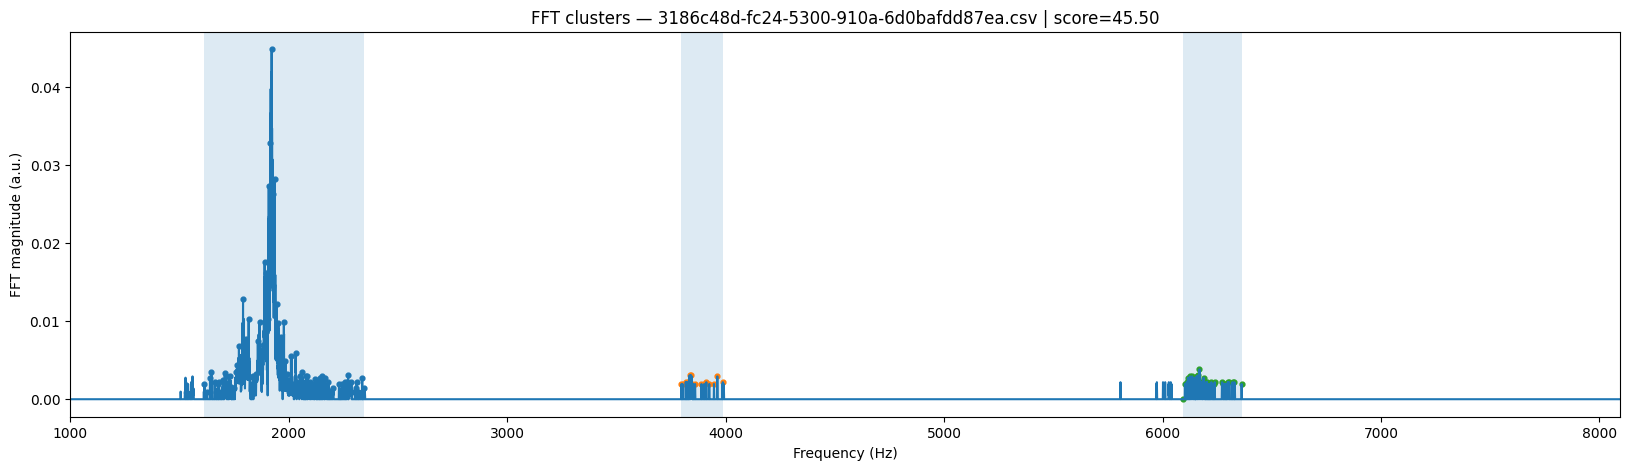

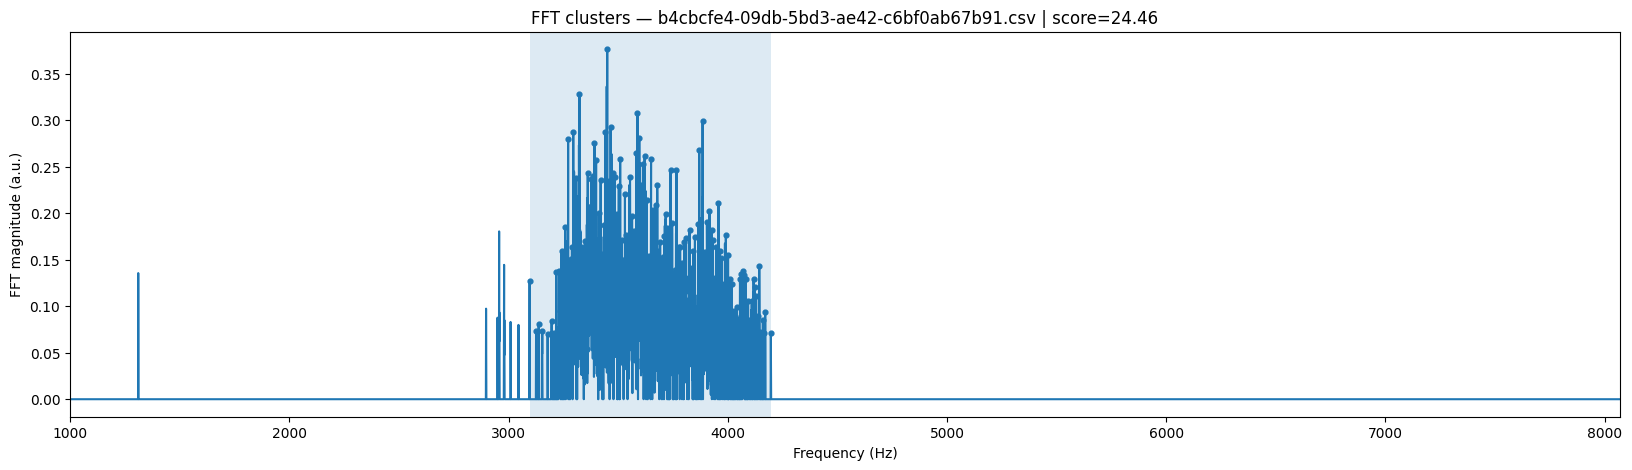

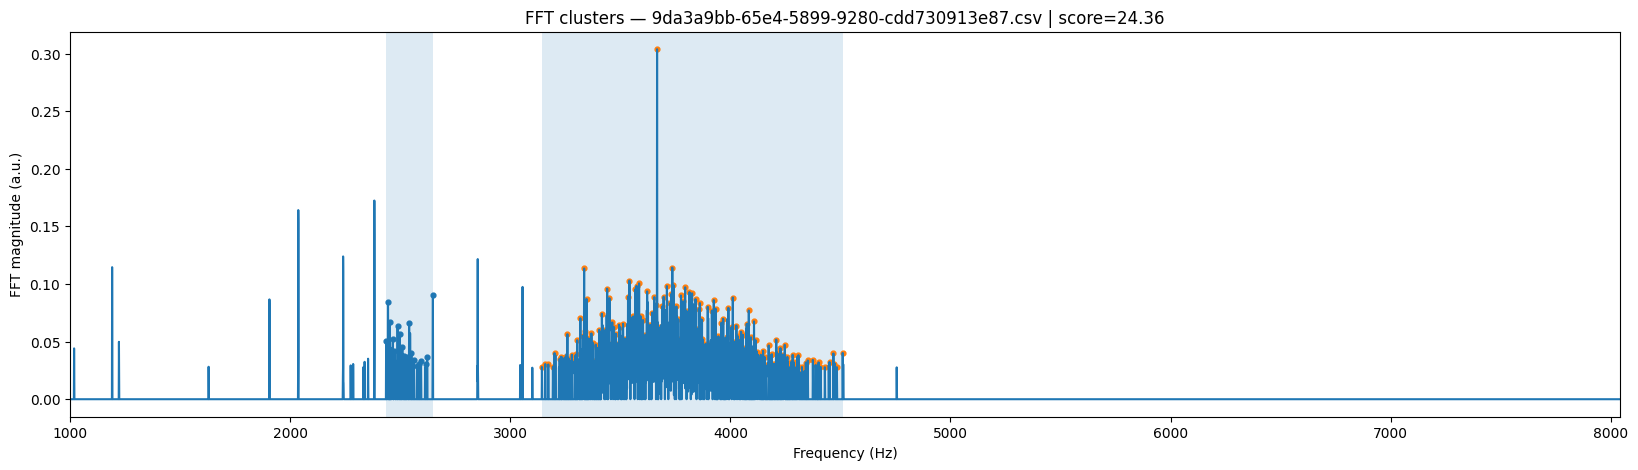

In [16]:
top_n = 3
top_files = rank_df["file"].head(top_n).tolist()

for fname in top_files:
    d = details[fname]
    plot_fft_with_clusters(
        f=d["f"],
        mag=d["mag"],
        clusters=d["clusters"],
        fmin=1000.0,
        fmax=float(d["f"].max()),
        title=f"FFT clusters — {fname} | score={d['score']:.2f}",
    )


### Methodological Note

Notebook 01 provided qualitative PSD-based diagnostics and exploratory heuristics
for broadband and carpet-like behavior.

However, no scalar severity score per sample was defined at that stage.

Notebook 02 introduces a formal FFT-based metric aligned with the challenge
definition, allowing objective ranking across samples.

The comparison between both notebooks therefore serves as a consistency check
between qualitative interpretation and quantitative formalization.


### Consistency Check vs Notebook 01

Notebook 01 performed a qualitative PSD-based diagnostic analysis,
focusing on broadband elevation and visually inspecting carpet-like regions.

At that stage, no scalar severity score was defined.  
The identification of the most carpet-like sample was based on:

- Visual inspection of clustered spectral peaks
- Evaluation of broadband behavior
- Absence of clearly dominant resonance peaks

During that qualitative assessment, the file  
`3186c48d-fc24-5300-910a-6d0bafdd87ea.csv`
was identified as presenting the strongest carpet-like behavior among the evaluated samples.

In Notebook 02, a formal FFT-based clustering metric was introduced,
quantifying:

- Peak density within dynamic frequency bands
- Irregularity of peak spacing (CV of Δf)
- Penalization of dominant peaks

Using this quantitative metric (top_k = 1),
the same file  
`3186c48d-fc24-5300-910a-6d0bafdd87ea.csv`
emerges as the highest-severity sample among the same 10 representative files.

This agreement between qualitative (PSD-based) and quantitative (FFT-based)
analyses increases confidence that the proposed severity metric
captures the intended carpet definition rather than overfitting
to a specific representation.


## 7. Full Dataset Evaluation (All Part 1 Samples)

After validating the FFT-based carpet severity metric on the 10 representative samples
and confirming consistency with the qualitative PSD-based diagnosis from Notebook 01,
we now extend the analysis to all available Part 1 files.

A total of 15 vibration samples are available in Part 1,
and all of them are evaluated using the same FFT-based clustering metric.

Objective:
Identify the sample presenting the worst carpet symptom,
as required by the challenge statement.

### Severity Definition

For this final evaluation:

- The severity score per sample is defined as the maximum cluster score (top_k = 1).
- This choice reflects the interpretation that a single strongly carpet-like band
  is sufficient to characterize a severe lubrication-related symptom.
- The metric incorporates:
  - Peak density within dynamic frequency bands
  - Irregularity of peak spacing (CV of Δf)
  - Penalization of dominant resonance peaks

### Expected Behavior

A true carpet-positive sample should exhibit:

- Dense clusters of irregularly spaced peaks
- No strong amplitude hierarchy within the band
- Spectral texture rather than modal amplification

The ranking below is computed across all Part 1 samples.


In [17]:
all_paths = sorted(Path("../data/part_1").glob("*.csv"))
print(f"Found {len(all_paths)} files.")

results = []
details = {}

for p in all_paths:
    r = score_file_carpet(
        p,
        k_peak=CFG["k_peak"],
        min_distance_hz=CFG["min_distance_hz"],
        gap_max_hz=CFG["gap_max_hz"],
        min_peaks_cluster=CFG["min_peaks_cluster"],
        top_k_clusters=CFG["top_k_clusters"],
        fmin_hz=CFG["fmin_hz"],
    )

    results.append({
        "file": r["file"],
        "fs_hz": r["fs_hz"],
        "rms": r["rms"],
        "n_peaks": r["n_peaks"],
        "n_clusters": r["n_clusters"],
        "score": r["score"],
    })

    details[r["file"]] = r

rank15_df = pd.DataFrame(results).sort_values("score", ascending=False).reset_index(drop=True)
rank15_df


Found 15 files.


,file,fs_hz,rms,n_peaks,n_clusters,score
0,3186c48d-fc24-5300-910a-6d0bafdd87ea.csv,16188.0,0.164300,147,3,45.497444
1,555cbc73-5a58-53a2-b432-c415f46e8c7c.csv,15834.0,2.801740,323,3,37.522935
2,b4cbcfe4-09db-5bd3-ae42-c6bf0ab67b91.csv,16140.0,2.710297,151,1,24.461912
3,9da3a9bb-65e4-5899-9280-cdd730913e87.csv,16084.0,1.031824,214,2,24.359870
4,771e32b1-39b4-5a58-bb2b-c618ce2701d8.csv,16194.0,1.229190,205,3,24.332369
5,ccd17931-56bc-5470-8a47-89356b267edd.csv,15842.0,1.170085,223,3,22.666985
6,f26b0d46-fb3e-5a2f-9121-73653390cb09.csv,16132.0,0.583547,198,3,21.051690
7,11d8b435-ba4a-564f-b0e8-d5cbed8adbb2.csv,15841.0,0.458106,177,2,20.823639
8,82e91f2f-4ed5-5591-9617-0ff6f3b0e0c1.csv,16173.0,1.554291,274,3,16.757064
9,b3f7bc7a-5414-5112-9028-49f4fd4a9072.csv,16100.0,0.705732,170,1,15.588727


1) 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv | score=45.497 | fs=16188.0 | rms=0.164 | clusters=3
2) 555cbc73-5a58-53a2-b432-c415f46e8c7c.csv | score=37.523 | fs=15834.0 | rms=2.802 | clusters=3
3) b4cbcfe4-09db-5bd3-ae42-c6bf0ab67b91.csv | score=24.462 | fs=16140.0 | rms=2.710 | clusters=1


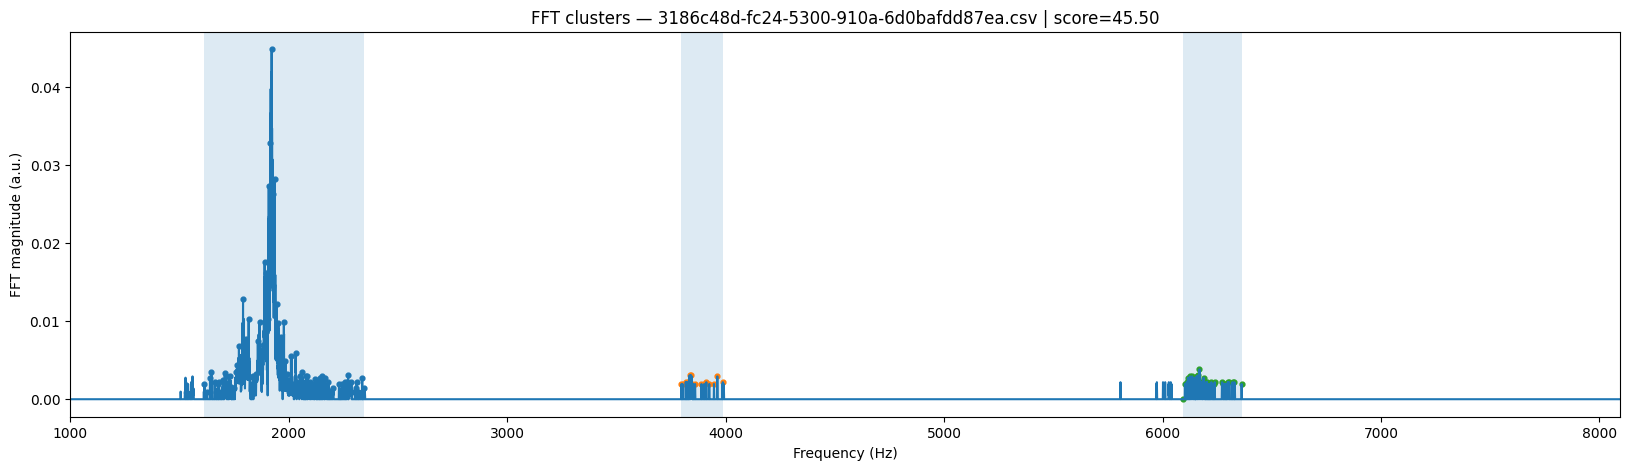

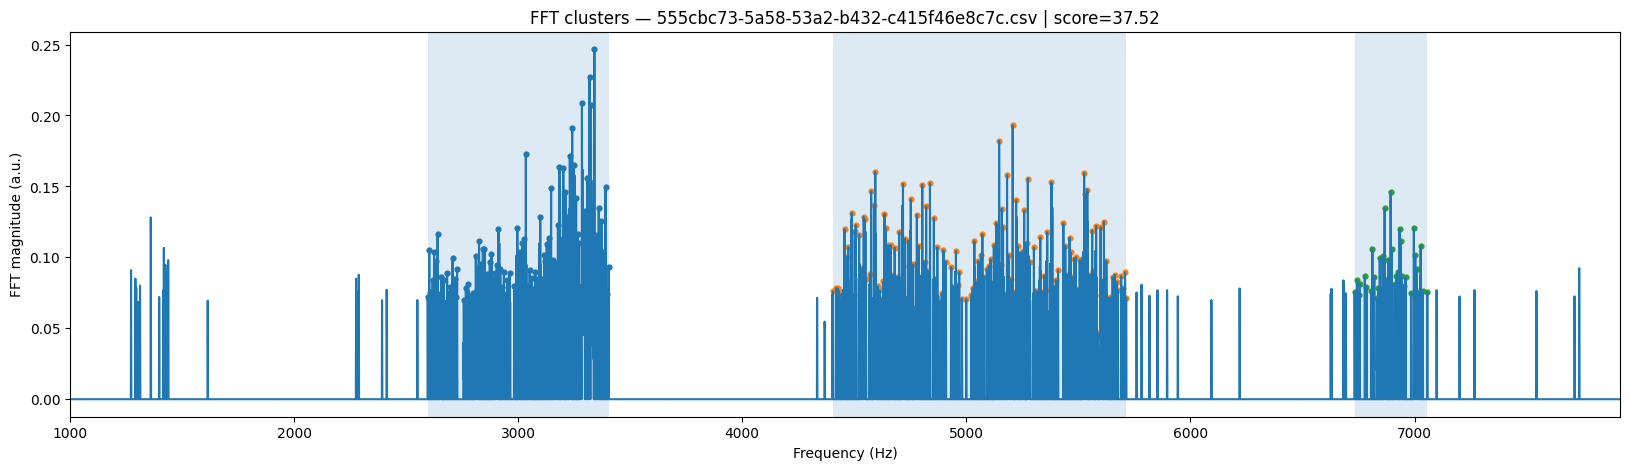

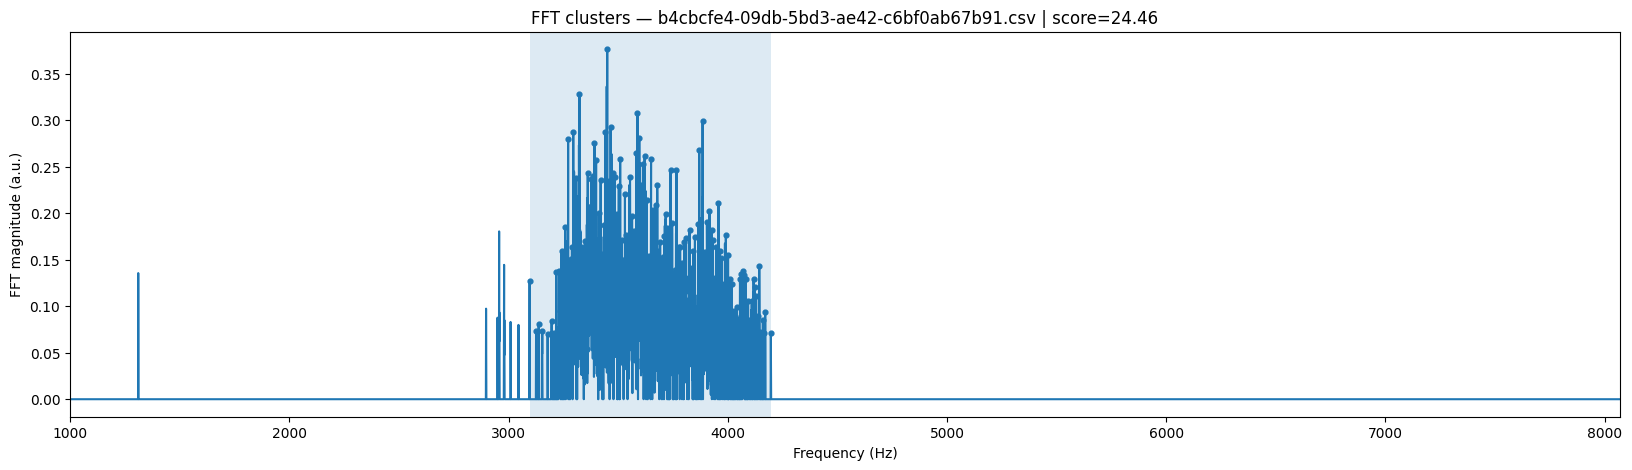

In [18]:
top3 = rank15_df.head(3)
for i, row in top3.iterrows():
    print(
        f"{i+1}) {row['file']} | "
        f"score={row['score']:.3f} | "
        f"fs={row['fs_hz']:.1f} | "
        f"rms={row['rms']:.3f} | "
        f"clusters={row['n_clusters']}"
    )

top_files = top3["file"].tolist()

for fname in top_files:
    d = details[fname]
    plot_fft_with_clusters(
        f=d["f"],
        mag=d["mag"],
        clusters=d["clusters"],
        fmin=1000.0,
        fmax=float(d["f"].max()),
        title=f"FFT clusters — {fname} | score={d['score']:.2f}",
    )


### Clustering Robustness Analysis — Sensitivity to `gap_max_hz`

The `gap_max_hz` parameter controls the maximum allowed frequency distance
between consecutive detected peaks for them to belong to the same cluster.

Conceptually:

- Smaller values (e.g., 25 Hz) tend to fragment wide peak-dense regions,
  possibly splitting a continuous carpet into multiple smaller clusters.
- Larger values (e.g., 50 Hz) may merge nearby clusters,
  potentially combining distinct physical phenomena.

Since carpet patterns are defined as *dense groups of randomly spaced peaks*,
rather than isolated harmonic structures,
it is important to verify that the ranking of the worst carpet symptom
is not an artifact of cluster fragmentation or over-merging.

Therefore, we perform a sensitivity analysis over:

- 25 Hz (conservative clustering)
- 35 Hz (balanced clustering)
- 50 Hz (more permissive clustering)

The goal is to ensure that:

- The highest-severity sample remains stable across reasonable parameter choices.
- The metric captures spectral texture rather than benefiting from arbitrary clustering thresholds.


In [23]:
def run_ranking_with_gap(gap: float) -> pd.DataFrame:
    all_paths = sorted(Path("../data/part_1").glob("*.csv"))
    rows = []
    for p in all_paths:
        r = score_file_carpet(
            p,
            k_peak=6.0,
            min_distance_hz=5.0,
            gap_max_hz=gap,
            min_peaks_cluster=8,
            top_k_clusters=1,
            fmin_hz=1000.0,
        )
        rows.append({"file": r["file"], "score": r["score"], "n_clusters": r["n_clusters"]})
    return pd.DataFrame(rows).sort_values("score", ascending=False).reset_index(drop=True)

rank25 = run_ranking_with_gap(25.0)
rank35 = run_ranking_with_gap(35.0)
rank50 = run_ranking_with_gap(50.0)

print("Top1 @25:", rank25.loc[0, "file"], rank25.loc[0, "score"])
print("Top1 @35:", rank35.loc[0, "file"], rank35.loc[0, "score"])
print("Top1 @50:", rank50.loc[0, "file"], rank50.loc[0, "score"])

rank25.head(5), rank35.head(5), rank50.head(5)


Top1 @25: 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv 64.44134471015056
Top1 @35: 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv 45.497443736659044
Top1 @50: 3186c48d-fc24-5300-910a-6d0bafdd87ea.csv 45.497443736659044


(                                       file      score  n_clusters
 0  3186c48d-fc24-5300-910a-6d0bafdd87ea.csv  64.441345           5
 1  555cbc73-5a58-53a2-b432-c415f46e8c7c.csv  38.787927           5
 2  6dbf3276-3d5a-5c9f-930e-09da6ec60243.csv  25.154053           2
 3  9da3a9bb-65e4-5899-9280-cdd730913e87.csv  22.624561           2
 4  ccd17931-56bc-5470-8a47-89356b267edd.csv  20.978157           3,
                                        file      score  n_clusters
 0  3186c48d-fc24-5300-910a-6d0bafdd87ea.csv  45.497444           3
 1  555cbc73-5a58-53a2-b432-c415f46e8c7c.csv  37.522935           3
 2  b4cbcfe4-09db-5bd3-ae42-c6bf0ab67b91.csv  24.461912           1
 3  9da3a9bb-65e4-5899-9280-cdd730913e87.csv  24.359870           2
 4  771e32b1-39b4-5a58-bb2b-c618ce2701d8.csv  24.332369           3,
                                        file      score  n_clusters
 0  3186c48d-fc24-5300-910a-6d0bafdd87ea.csv  45.497444           3
 1  555cbc73-5a58-53a2-b432-c415f46e8c7c.csv  

### Final Choice of `gap_max_hz`

The clustering gap parameter was evaluated at three levels:
25 Hz, 35 Hz, and 50 Hz.

Across all tested configurations, the same file:

`3186c48d-fc24-5300-910a-6d0bafdd87ea.csv`

remained the highest-severity sample.

This stability indicates that:

- The ranking of the worst carpet symptom is not driven by
  artificial cluster fragmentation (small gap values).
- Nor is it caused by excessive merging of distinct regions
  (large gap values).
- The severity metric is robust to reasonable variations
  in clustering tolerance.

Observed behavior:

- At 25 Hz, clusters are more fragmented.
- At 50 Hz, clusters become more permissive and may merge nearby structures.
- At 35 Hz, cluster cohesion improves while preserving separation
  between physically distinct regions.

Therefore, `gap_max_hz = 35 Hz` is selected as a balanced configuration,
minimizing fragmentation without introducing over-merging.

Importantly, the identity of the worst carpet sample
remains unchanged across all tested values,
reinforcing confidence in the proposed severity metric.


## 8. Final Answer — Worst Carpet Symptom

Based on the FFT-based carpet severity metric applied to all 15 Part 1 samples,
the file:

`3186c48d-fc24-5300-910a-6d0bafdd87ea.csv`

presents the highest carpet severity score.

### Justification

The conclusion is supported by multiple independent observations:

1. **Highest Severity Score**
   - The file consistently ranks first across all tested clustering tolerances
     (25 Hz, 35 Hz, and 50 Hz).
   - The ranking remains stable despite parameter variation,
     demonstrating robustness of the metric.

2. **Spectral Texture Characteristics**
   - The dominant band (~1700–2100 Hz) exhibits:
     - High peak density
     - Irregular peak spacing
     - No single strongly dominant resonance
   - This structure aligns with the challenge definition of carpet:
     *“a series of spectral peaks that are randomly close to each other.”*

3. **Absence of Dominant Harmonic Structure**
   - Unlike other high-energy samples,
     this file does not show clear harmonic regularity
     or a strong modal envelope dominating the band.
   - The pattern resembles broadband spectral roughness
     rather than a structural resonance.

4. **Consistency with Qualitative PSD Inspection**
   - In Notebook 01, the same sample was qualitatively identified
     as the most carpet-like region using broadband PSD analysis.
   - The FFT-based quantitative metric confirms this interpretation.

### Interpretation in Physical Terms

Carpet patterns are commonly associated with lubrication-related degradation,
where energy spreads across a frequency band and manifests as
densely packed, irregular peaks rather than isolated resonances.

The spectral behavior observed in this sample is consistent with
such broadband textural behavior, making it the most likely candidate
for severe carpet-related symptom within the evaluated dataset.

---

**Final Conclusion:**  
The sample `3186c48d-fc24-5300-910a-6d0bafdd87ea.csv`
is identified as the one presenting the worst carpet symptom in Part 1.
